
##  Cos'è il Machine Learning Unsupervised?

---

###  Obiettivo:

Spiegare il concetto di **Machine Learning non supervisionato**, la differenza rispetto al supervisionato, e introdurre le **due grandi famiglie**: **clustering** e **riduzione di dimensionalità**.

---

##  PARTE 1 — Supervised vs Unsupervised Learning

###  Supervised Learning (Apprendimento supervisionato)

Nel supervised learning:

* I dati **hanno etichette**.
* Il modello impara da esempi etichettati.
* Obiettivo: **predire un valore o una categoria**.

**Esempi**:

* Email → spam o non spam.
* Prezzo di una casa → in euro.

**Dataset d'esempio**:

```python
# Esempio semplificato
# X = caratteristiche (dimensione casa, quartiere, camere)
# y = prezzo in euro

X = [[100, 'centro', 2], [80, 'periferia', 1], ...]
y = [300000, 200000, ...]
```

---

###  Unsupervised Learning (Apprendimento non supervisionato)

Nel unsupervised:

* **Non abbiamo etichette**, solo i dati grezzi.
* Il modello cerca **strutture** o **pattern nascosti**.
* Obiettivo: trovare **gruppi**, **regolarità**, **anomalie** o **sintesi**.

**Due grandi famiglie:**

* **Clustering**: raggruppa dati simili (es. segmentazione clienti)
* **Riduzione di dimensionalità**: semplifica dati mantenendo l'informazione essenziale

**Esempio pratico:**
Dataset clienti Olist
→ Non sappiamo in partenza chi sono i clienti "fedeli" o "problematici"
→ Li scopriamo **automaticamente** raggruppando quelli con comportamenti simili!

---

##  PARTE 2 — Esempio con il dataset Olist (Kaggle)

### Dataset: Brazilian E-Commerce Public Dataset by Olist

 Comprende:

* clienti
* ordini
* prodotti
* venditori
* pagamenti
* recensioni

> Noi lavoreremo sulla **segmentazione clienti** → quindi costruiremo **feature sintetiche** da `orders`, `payments`, `reviews`.

---

##  ESEMPIO CODICE BASE: Preparare i dati

```python
import pandas as pd

# Caricamento dei file necessari
customers = pd.read_csv("olist_customers_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")

# Uniamo i dati per ogni cliente
df = orders.merge(customers, on='customer_id', how='left') \
           .merge(payments, on='order_id', how='left') \
           .merge(reviews, on='order_id', how='left')

# Calcoliamo caratteristiche utili per il clustering
customer_features = df.groupby('customer_unique_id').agg({
    'order_id': 'count',  # frequenza
    'payment_value': 'sum',  # spesa totale
    'review_score': 'mean',  # qualità esperienza
}).rename(columns={
    'order_id': 'num_orders',
    'payment_value': 'total_spent',
    'review_score': 'avg_review'
}).reset_index()

customer_features.head()
```

---

##  Output:

| customer\_unique\_id | num\_orders | total\_spent | avg\_review |
| -------------------- | ----------- | ------------ | ----------- |
| 012345abcd...        | 3           | 340.50       | 4.33        |
| 09fde12abc...        | 1           | 89.90        | 5.00        |
| ...                  | ...         | ...          | ...         |

> Questi dati sono **perfetti per clustering**: ci dicono **quanto spende il cliente**, **quante volte ha ordinato**, e **quanto è soddisfatto**.

---

##  PARTE 3 — Pipeline tipica Unsupervised

1. **Raccolta dati**  (già fatto sopra)
2. **Pulizia dati**: rimuovere NaN, gestire outlier
3. **Feature engineering**: creare colonne utili (es. RFM)
4. **Standardizzazione**: rescale dei dati (importantissimo!)
5. **Modello**: applichiamo k-Means, DBSCAN o altri
6. **Valutazione qualitativa** (silhouette, visualizzazione 2D)
7. **Interpretazione dei gruppi**

---

###  Concetto matematico chiave: Distanza

Tutto l’unsupervised parte dal concetto di **distanza** tra punti.

* Spesso si usa **distanza euclidea**
* Se due clienti sono molto “vicini” → comportamenti simili

**Esempio:**

```python
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

X = customer_features[['num_orders', 'total_spent', 'avg_review']]
X_scaled = StandardScaler().fit_transform(X)

# Distanza tra i primi due clienti
dist = euclidean_distances([X_scaled[0]], [X_scaled[1]])
print("Distanza tra cliente 0 e 1:", dist)
```

---




##  4. Cos’è il Clustering

###  Cos’è il clustering?

Clustering = **raggruppare dati simili tra loro** in gruppi (cluster), **senza etichette**.
L’algoritmo decide chi somiglia a chi, basandosi su una misura di **distanza**.

**Obiettivo**: scoprire **strutture nascoste** nel dataset.

---

###  Esempio visivo intuitivo:

Immaginiamo di avere tanti punti su un piano, ciascuno rappresenta un cliente. Vogliamo trovare gruppi che **si assomigliano**:

####  ESEMPIO GRAFICO



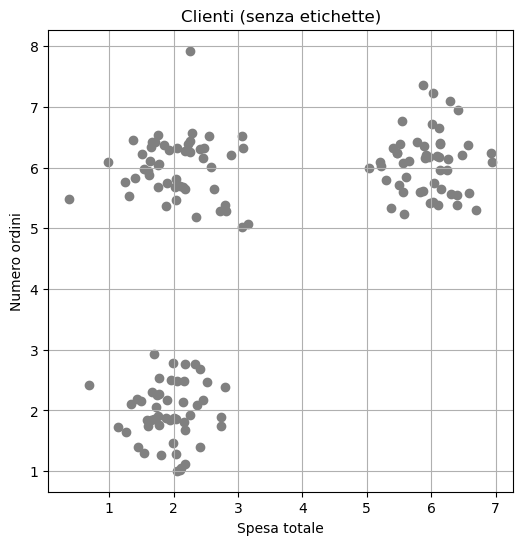

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Generiamo 3 gruppi di punti (cluster)
np.random.seed(42)
group1 = np.random.normal(loc=[2, 2], scale=0.5, size=(50, 2))
group2 = np.random.normal(loc=[6, 6], scale=0.5, size=(50, 2))
group3 = np.random.normal(loc=[2, 6], scale=0.5, size=(50, 2))

data = np.vstack((group1, group2, group3))

# Visualizziamo i punti (senza clustering)
plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], c='gray')
plt.title("Clienti (senza etichette)")
plt.xlabel("Spesa totale")
plt.ylabel("Numero ordini")
plt.grid(True)
plt.show()

---

##  Come funziona k-Means?

k-Means cerca di **dividere i punti in k gruppi**, dove **ogni punto è assegnato al centro più vicino**.

### Passaggi:

1. Scegli `k` (numero di cluster)
2. Inizializza `k` **centroidi** casuali
3. **Assegna ogni punto** al centro più vicino
4. **Ricalcola i centroidi** come media dei punti assegnati
5. Ripeti finché i centroidi **non cambiano più**

---
##  Matematica dietro k-Means

1. **Distanza Euclidea** (tra punto e centroide):

$$
d(\mathbf{x}, \mathbf{c}) = \sqrt{(x_1 - c_1)^2 + (x_2 - c_2)^2 + \dots + (x_n - c_n)^2}
$$

2. **Funzione da minimizzare** (somma delle distanze quadrate tra ogni punto e il proprio centroide):

$$
J = \sum_{i=1}^{k} \sum_{\mathbf{x} \in C_i} \|\mathbf{x} - \mu_i\|^2
$$

Dove:

* $C_i$ è il cluster i-esimo
* $\mu_i$ è il centroide del cluster
* $\|\mathbf{x} - \mu_i\|$ è la distanza tra punto e centroide

---

##  Esempio con `KMeans` e visualizzazione (dati fittizi)


C:\Users\mbagn\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\mbagn\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\mbagn\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mbagn\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\mbagn\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

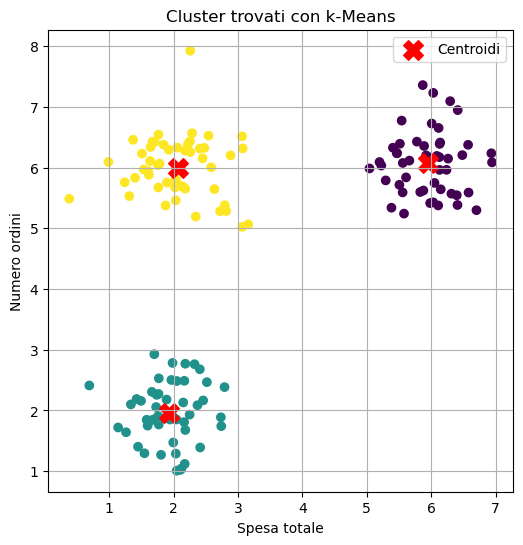

In [3]:
from sklearn.cluster import KMeans

# Applichiamo k-Means ai dati generati
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(data)

# Visualizzazione con i cluster trovati
plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            c='red', marker='X', s=200, label='Centroidi')
plt.title("Cluster trovati con k-Means")
plt.xlabel("Spesa totale")
plt.ylabel("Numero ordini")
plt.legend()
plt.grid(True)
plt.show()


##  Interpretazione del grafico:

* Ogni colore = un **gruppo scoperto automaticamente**
* I punti rossi = **centroidi**
* I cluster possono essere usati per:

  * Profilare clienti
  * Fare marketing mirato
  * Prevedere comportamenti futuri

---


---

##  **Cos’è il Silhouette Score?**

Il **Silhouette Score** valuta **quanto un punto è ben assegnato al proprio cluster** rispetto agli altri.

Per ogni punto:

* Confronta **la coesione interna** (quanto è vicino agli altri del proprio cluster)
* Con la **separazione** (quanto è distante dai punti del cluster più vicino)

---

##  Formula:

Per ogni punto $i$:

* $a(i)$ = **media delle distanze** tra il punto e gli altri punti del **suo cluster**
* $b(i)$ = **distanza più bassa** tra il punto e i punti di un altro cluster (il più vicino)

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

* Il valore finale è tra **-1 e 1**

  * Vicino a **1** → punto ben assegnato
  * Circa **0** → punto al confine tra due cluster
  * Negativo → punto assegnato al **cluster sbagliato**

---

##  Interpretazione media Silhouette Score (su tutto il dataset):

| Silhouette Score | Interpretazione                 |
| ---------------- | ------------------------------- |
| > 0.7            | Cluster ben definiti            |
| 0.5 – 0.7        | Cluster buoni                   |
| 0.3 – 0.5        | Cluster deboli / sovrapposti    |
| < 0.3            | Cluster poco chiari / non utili |

---



C:\Users\mbagn\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


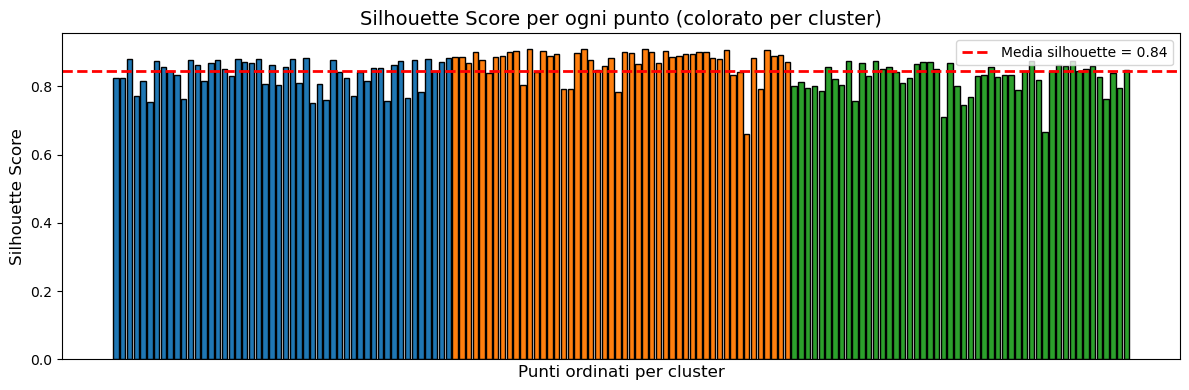

In [7]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np

# Generiamo dati di esempio
X, _ = make_blobs(n_samples=150, centers=3, cluster_std=1.0, random_state=42)

# Applichiamo k-Means
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)

# Calcolo dei silhouette score
silhouette_avg = silhouette_score(X, labels)
sample_silhouette_values = silhouette_samples(X, labels)

# Preparo i dati ordinati per cluster e silhouette
sorted_labels = np.argsort(labels)
sorted_scores = sample_silhouette_values[sorted_labels]
sorted_clusters = labels[sorted_labels]

# Colori assegnati ai cluster per chiarezza
cluster_colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c"}
bar_colors = [cluster_colors[c] for c in sorted_clusters]

# Grafico semplificato e molto leggibile
plt.figure(figsize=(12, 4))
plt.bar(range(len(X)), sorted_scores, color=bar_colors, edgecolor='black')
plt.axhline(silhouette_avg, color='red', linestyle='--', linewidth=2, label=f'Media silhouette = {silhouette_avg:.2f}')
plt.title("Silhouette Score per ogni punto (colorato per cluster)", fontsize=14)
plt.xlabel("Punti ordinati per cluster", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.xticks([])
plt.legend()
plt.tight_layout()
plt.show()


---

##  A cosa serve in pratica?

* **Scegliere il miglior numero di cluster `k`**:

  * Prova k = 2, 3, 4, … e scegli il valore con silhouette medio più alto.
* Capire se ci sono **cluster troppo sovrapposti**
* **Visualizzare anomalie** → i punti con silhouette negativo!

---


C:\Users\mbagn\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\mbagn\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\mbagn\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\mbagn\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

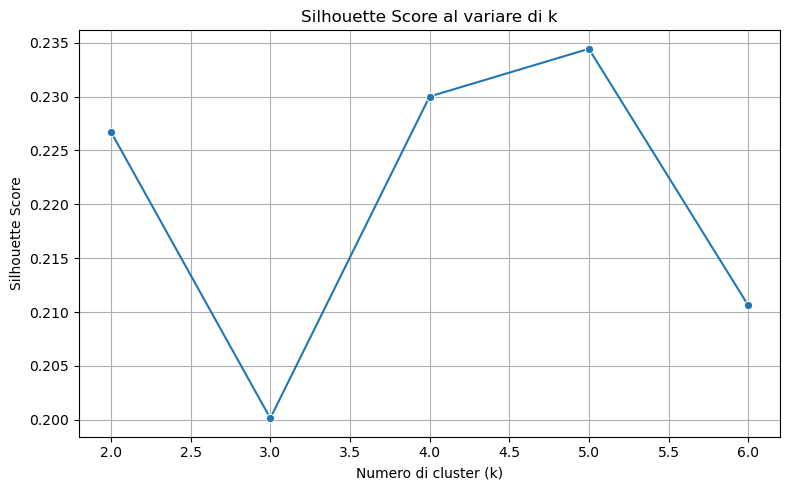

In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Simuliamo un dataset Olist semplificato per l'esercizio
np.random.seed(42)
n_customers = 500

olist_df = pd.DataFrame({
    'customer_id': [f"C{i}" for i in range(n_customers)],
    'recency_days': np.random.exponential(scale=90, size=n_customers),  # giorni dall’ultimo ordine
    'frequency_orders': np.random.poisson(lam=3, size=n_customers),      # numero ordini
    'monetary_total': np.random.gamma(shape=2, scale=150, size=n_customers),  # spesa totale
    'avg_review_score': np.clip(np.random.normal(loc=4, scale=0.5, size=n_customers), 1, 5)  # recensioni
})

# Rimuoviamo clienti con 0 ordini (eventuali errori)
olist_df = olist_df[olist_df['frequency_orders'] > 0]

# Selezioniamo le feature per il clustering
features = ['recency_days', 'frequency_orders', 'monetary_total', 'avg_review_score']
X = olist_df[features]

# Standardizziamo
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Proviamo diversi k e salviamo silhouette score
silhouette_scores = []
K = range(2, 7)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Grafico silhouette score per diversi k
plt.figure(figsize=(8, 5))
sns.lineplot(x=list(K), y=silhouette_scores, marker='o')
plt.title("Silhouette Score al variare di k")
plt.xlabel("Numero di cluster (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()


### Gara a chi ottiene il miglior punteggio silhouette su https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_customers_dataset.csv


---

##  **8. Cos’è DBSCAN? – Density-Based Spatial Clustering of Applications with Noise**

###  In breve:

* DBSCAN è un algoritmo di clustering che **non richiede di specificare `k`**, il numero di cluster.
* Invece di creare gruppi per distanza dai centroidi (come k-Means), **trova zone ad alta densità di punti** e li considera **cluster**.
* I punti **isolati o in zone a bassa densità** vengono considerati **outlier**.

---

##  DBSCAN è ottimo quando:

| ✔️ | Dati hanno **forma irregolare** (non circolare) |
| -- | ----------------------------------------------- |
| ✔️ | Ci sono **outlier o rumore** da escludere       |
| ✔️ | Non si sa quanti cluster scegliere in partenza  |

---

##  Concetti fondamentali

### 1. `eps`: **raggio massimo**

* Raggio entro cui un punto cerca **vicini**
* Se trovo abbastanza vicini, è un **punto centrale (core)**

### 2. `min_samples`: **densità minima**

* Numero minimo di punti nel raggio `eps` per formare un cluster

### 3. Tipi di punti:

| Tipo       | Descrizione                                                     |
| ---------- | --------------------------------------------------------------- |
| **Core**   | Ha abbastanza vicini (≥ `min_samples`)                          |
| **Border** | Ha meno vicini, ma è vicino a un core                           |
| **Noise**  | Non è core né border → considerato **outlier** (etichetta = -1) |

---

##  ESEMPIO VISIVO

Immagina di avere punti distribuiti così:

```
x x x         o o
 x x x   x       o o o
x x x x x   o o o o o o
```

* k-Means farebbe **cerchi simmetrici** (anche se non ha senso)
* DBSCAN invece **trova le zone dense**, anche se di forma strana, e lascia fuori i punti isolati

---

##  k-Means vs DBSCAN

| Caratteristica         | k-Means                  | DBSCAN                     |
| ---------------------- | ------------------------ | -------------------------- |
| Bisogna scegliere `k`? | ✅ Sì                     | ❌ No                       |
| Forma cluster          | 🔴 Circolari             | 🟢 Qualsiasi               |
| Gestione outlier       | ❌ Li forza in un cluster | ✅ Li ignora (etichetta -1) |
| Velocità               | 🟢 Veloce                | 🟡 Più lento               |
| Dati ad alta densità   | ❌ Male                   | ✅ Bene                     |

---




C:\Users\mbagn\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


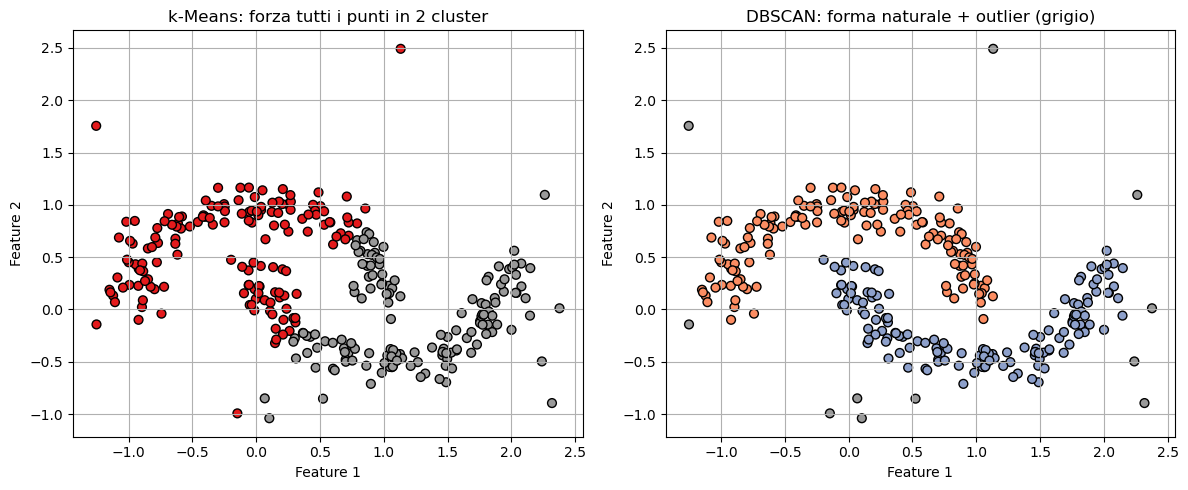

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans, DBSCAN

# Generazione di dati a forma non circolare (mezzalune) + aggiunta outlier
from sklearn.datasets import make_moons

# Dati principali
X_base, _ = make_moons(n_samples=280, noise=0.1, random_state=42)

# Outlier casuali distribuiti nello spazio
outliers = np.random.uniform(low=-1.5, high=2.5, size=(20, 2))

# Concatenazione
X_with_outliers = np.vstack((X_base, outliers))

# k-Means clustering (forzato in 2 gruppi)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_with_outliers)

# DBSCAN clustering (basato sulla densità, senza specificare k)
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_with_outliers)

# Assegna colori ai cluster DBSCAN (grigio per outlier, colori per cluster)
unique_labels = set(dbscan_labels)
palette = sns.color_palette("Set2", len(unique_labels))
color_map = {
    label: palette[i] if label != -1 else (0.6, 0.6, 0.6)  # grigio per outlier
    for i, label in enumerate(sorted(unique_labels))
}
colors_dbscan = [color_map[label] for label in dbscan_labels]

# Visualizzazione: k-Means vs DBSCAN
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# k-Means
axs[0].scatter(X_with_outliers[:, 0], X_with_outliers[:, 1], c=kmeans_labels, cmap='Set1', s=40, edgecolor='black')
axs[0].set_title("k-Means: forza tutti i punti in 2 cluster")
axs[0].set_xlabel("Feature 1")
axs[0].set_ylabel("Feature 2")
axs[0].grid(True)

# DBSCAN
axs[1].scatter(X_with_outliers[:, 0], X_with_outliers[:, 1], c=colors_dbscan, s=40, edgecolor='black')
axs[1].set_title("DBSCAN: forma naturale + outlier (grigio)")
axs[1].set_xlabel("Feature 1")
axs[1].set_ylabel("Feature 2")
axs[1].grid(True)

plt.tight_layout()
plt.show()




---

##  A sinistra: **k-Means**

* Forza tutti i punti in **2 cluster circolari**, anche se:

  * Le forme dei dati sono **a mezzaluna**
  * I punti **al confine** vengono mal assegnati
* Non riconosce **outlier** → ogni punto deve per forza appartenere a un gruppo

---

##  A destra: **DBSCAN**

* Ha trovato **2 cluster ben distinti**, seguendo la **forma naturale** delle mezzalune
* I punti **in grigio** sono stati etichettati come **outlier** (etichetta `-1`)

  * Significa che **non appartengono a nessuna zona ad alta densità**
  * DBSCAN li esclude automaticamente

---

##  Conclusione:

> “k-Means ha bisogno di sapere `k` e crea gruppi sempre a forma di cerchio. Invece DBSCAN **scopre da solo quanti gruppi ci sono**, anche se hanno forme strane, e riesce a **trovare i punti che non appartengono a nessun gruppo**, ovvero gli outlier. Questo è utilissimo in molti casi del mondo reale.”

---



## APPLICARE DBSCAN CON OPTUNA SUL DATASET

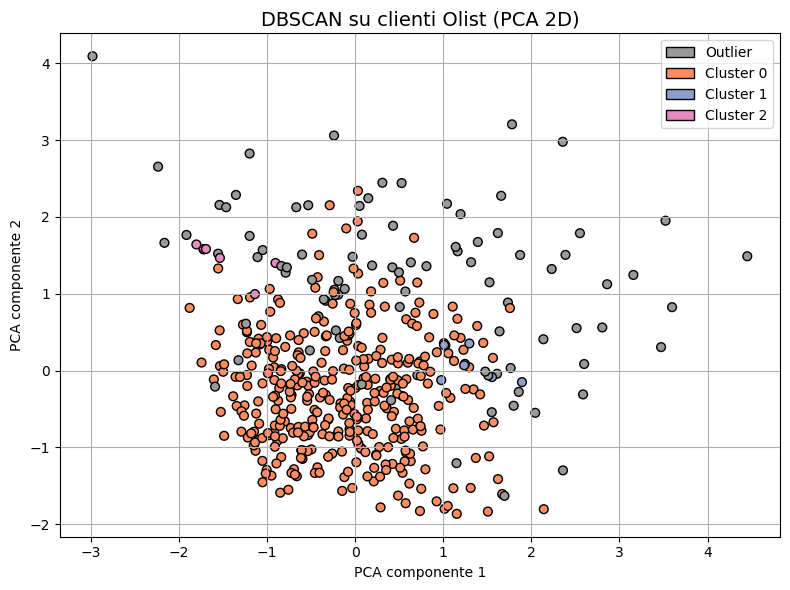

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import pandas as pd

# Simuliamo un dataset Olist (come fatto in precedenza)
np.random.seed(42)
n_customers = 500
olist_df = pd.DataFrame({
    'customer_id': [f"C{i}" for i in range(n_customers)],
    'recency_days': np.random.exponential(scale=90, size=n_customers),
    'frequency_orders': np.random.poisson(lam=3, size=n_customers),
    'monetary_total': np.random.gamma(shape=2, scale=150, size=n_customers),
    'avg_review_score': np.clip(np.random.normal(loc=4, scale=0.5, size=n_customers), 1, 5)
})
olist_df = olist_df[olist_df['frequency_orders'] > 0]

# Selezione delle feature
features = ['recency_days', 'frequency_orders', 'monetary_total', 'avg_review_score']
X = olist_df[features]

# Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA per visualizzazione 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# DBSCAN clustering
dbscan = DBSCAN(eps=0.8, min_samples=6)  # Parametri scelti con tolleranza ampia
db_labels = dbscan.fit_predict(X_scaled)

# Colori per i cluster DBSCAN
unique_labels = set(db_labels)
palette = sns.color_palette("Set2", len(unique_labels))
color_map = {
    label: palette[i] if label != -1 else (0.6, 0.6, 0.6)
    for i, label in enumerate(sorted(unique_labels))
}
colors = [color_map[label] for label in db_labels]

# Visualizzazione su PCA 2D
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, s=40, edgecolor='black')
plt.title("DBSCAN su clienti Olist (PCA 2D)", fontsize=14)
plt.xlabel("PCA componente 1")
plt.ylabel("PCA componente 2")
plt.grid(True)

# Legenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=color_map[label], edgecolor='black',
          label=f"Cluster {label}" if label != -1 else "Outlier")
    for label in sorted(unique_labels)
]
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()



---

#  11. Riduzione di dimensionalità – PCA (Principal Component Analysis)


---

##  Perché ridurre le dimensioni?

In molti dataset reali (come quello di Olist), abbiamo **tante colonne (feature)**:

| Problema                    | Effetto                                                                       |
| --------------------------- | ----------------------------------------------------------------------------- |
| ❌ Troppe dimensioni         | Difficile da **visualizzare** e interpretare                                  |
| ❌ Feature ridondanti        | Più colonne portano **informazione simile**, creano rumore                    |
| ❌ Algoritmi più lenti       | Computazioni più complesse, specialmente con modelli avanzati                 |
| ❌ "Curse of Dimensionality" | Aumenta il rischio di **overfitting** e diminuisce l'efficacia del clustering |

---

##  Cosa fa la PCA?

La **Principal Component Analysis (PCA)** è una tecnica che:

* **Trasforma** i dati in un **nuovo sistema di coordinate**
* Le **nuove dimensioni** si chiamano **componenti principali**
* Ogni componente è **una combinazione delle feature originali**
* **Ordinamento per varianza**: la 1ª componente spiega la maggior parte della variazione dei dati, poi la 2ª, ecc.

---

##  Obiettivo della PCA

**Trovare la miglior proiezione** dei dati su **2 o 3 assi** mantenendo **più informazione possibile**.

---

###  Metafora visiva:

Immagina di avere un punto nello spazio 3D. Vuoi proiettarlo su un foglio 2D:

* La PCA cerca l’**orientamento del foglio** che preserva al massimo le distanze tra i punti (cioè la **varianza**).

---

##  Dietro le quinte :

1. Calcola la **covarianza** tra le feature
2. Trova le **direzioni (vettori)** dove la varianza è massima
3. Proietta i dati su queste nuove direzioni

$$
X_{\text{PCA}} = X \cdot W
$$

Dove:

* $X$ = dati originali
* $W$ = matrice con i **vettori principali** (eigenvectors)

---

##  ESEMPIO VISIVO CON OLIST – PCA 2D

Useremo lo stesso dataset clienti Olist, e ridurremo le dimensioni da 4 a 2 per:

* Visualizzare il **clustering**
* Capire se i gruppi sono **ben separati**



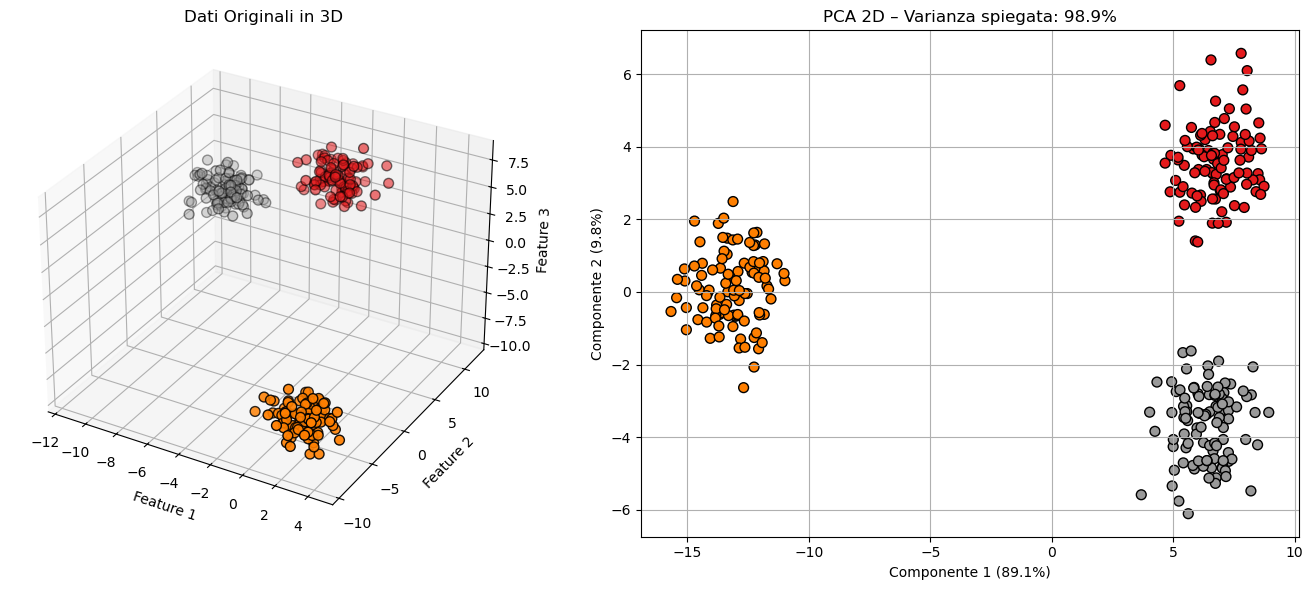

In [15]:
# Esempio didattico: dati 3D proiettati in 2D con PCA
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D

# 1. Generiamo un dataset artificiale in 3D con 3 gruppi distinti
X_3d, y_3d = make_blobs(n_samples=300, centers=3, n_features=3, random_state=42)

# 2. Applichiamo la PCA per ridurre da 3D a 2D
pca_3d = PCA(n_components=2)
X_2d = pca_3d.fit_transform(X_3d)
explained = pca_3d.explained_variance_ratio_

# 3. Visualizzazione a confronto: 3D originale vs PCA 2D

fig = plt.figure(figsize=(14, 6))

# Plot originale in 3D
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
scatter3d = ax1.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=y_3d, cmap='Set1', s=50, edgecolor='k')
ax1.set_title("Dati Originali in 3D")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_zlabel("Feature 3")

# Plot dopo PCA in 2D
ax2 = fig.add_subplot(1, 2, 2)
scatter2d = ax2.scatter(X_2d[:, 0], X_2d[:, 1], c=y_3d, cmap='Set1', s=50, edgecolor='k')
ax2.set_title(f"PCA 2D – Varianza spiegata: {explained.sum():.1%}")
ax2.set_xlabel(f"Componente 1 ({explained[0]:.1%})")
ax2.set_ylabel(f"Componente 2 ({explained[1]:.1%})")
ax2.grid(True)

plt.tight_layout()
plt.show()



---

##  **PCA: struttura base in scikit-learn**

```python
from sklearn.decomposition import PCA

pca = PCA(n_components=..., svd_solver=..., whiten=..., random_state=...)
X_pca = pca.fit_transform(X)
```

---

##  Obiettivo della PCA:

**Ridurre le dimensioni del dataset**, mantenendo più **informazione (varianza)** possibile.

---

##  **Parametri principali della PCA**

| Parametro      | Tipo                                           | Descrizione                                                              | Quando usarlo                                       |
| -------------- | ---------------------------------------------- | ------------------------------------------------------------------------ | ---------------------------------------------------- |
| `n_components` | `int`, `float`, `"mle"`, `None`                | **Numero di componenti** da mantenere                                    |  Vedi sotto                                        |
| `svd_solver`   | `"auto"`, `"full"`, `"arpack"`, `"randomized"` | Algoritmo per decomposizione (auto è ok di solito)                       | Solo in casi avanzati                                |
| `whiten`       | `True/False`                                   | Rende le componenti **decorrelate e con varianza unitaria** (normalizza) | Solo per modelli che richiedono input standardizzati |
| `random_state` | `int`                                          | Fissa la casualità per riproducibilità, usato con `"randomized"` solver  | Per avere risultati ripetibili                       |

---

##  Il parametro più importante: `n_components`

Vediamo **come può essere usato**, a seconda delle esigenze:

---

###  1. **Ridurre a un numero specifico di componenti**

```python
PCA(n_components=2)
```

 Mantiene **solo le prime 2 componenti principali** → utile per visualizzazioni 2D o 3D.

---

###  2. **Mantenere una certa % di varianza spiegata**

```python
PCA(n_components=0.95)
```

 Mantiene **il numero minimo di componenti** che spiegano almeno il **95% della varianza**.

> Perfetto per quando vogliamo **compressione con poca perdita di informazione.**

---

###  3. **Automatica (`mle`)**

```python
PCA(n_components='mle', svd_solver='full')
```

 Stima il numero ottimale di componenti usando il criterio **MLE (Maximum Likelihood Estimation)**.

> Funziona solo se il numero di osservazioni > numero di feature. Non sempre stabile.

---

###  4. **Mantieni tutte le componenti (solo per analisi)**

```python
PCA(n_components=None)
```

 Nessuna riduzione, ma puoi analizzare **quanta varianza spiega ogni componente** con:

```python
pca = PCA()
pca.fit(X)
print(pca.explained_variance_ratio_)
```

---

##  Esempio completo commentato




In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Standardizza i dati (sempre importante!)
X_scaled = StandardScaler().fit_transform(X)

# 2. Applica PCA per ridurre a 2 dimensioni
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 3. Analizza la varianza spiegata
print("Varianza spiegata da ogni componente:", pca.explained_variance_ratio_)
print("Totale varianza spiegata:", pca.explained_variance_ratio_.sum())

Varianza spiegata da ogni componente: [0.26351818 0.25291051]
Totale varianza spiegata: 0.5164286863502119


##  Best practice:

* **Standardizza sempre i dati** prima della PCA!
* Se vuoi fare clustering o classificazione dopo la PCA, considera `whiten=True` (rende i dati con varianza 1).
* Scegli `n_components=0.95` per un buon compromesso tra compressione e qualità.
* Usa `n_components=2` solo per **visualizzazione**, non per modellazione vera.

---

## Applicare la PCA sul dataset e poi il dbscan 


---

##  **t-SNE / UMAP – Tecniche di visualizzazione non lineari**

Queste tecniche sono **alternative avanzate alla PCA**, usate **solo per visualizzare i dati**, non per modelli.
Sono particolarmente utili quando:

* Vuoi visualizzare **strutture nascoste nei dati ad alta dimensionalità**
* Vuoi capire **come i dati si raggruppano** in cluster
* Stai usando tecniche di **clustering** o **analisi esplorativa**

---

##  Differenze fondamentali

| Caratteristica        | **PCA**                       | **t-SNE**                             | **UMAP**                                   |
| --------------------- | ----------------------------- | ------------------------------------- | ------------------------------------------ |
| Tipo                  | Lineare                       | Non lineare                           | Non lineare                                |
| Obiettivo             | Mantiene **varianza globale** | Mantiene **vicinanza locale**         | Mantiene **vicinanza + struttura globale** |
| Uso principale        | Compressione, modelli         | Visualizzazione                       | Visualizzazione                            |
| Velocità              | 🚀 Molto veloce               | 🐢 Lento su grandi dataset            | ⚡ Più veloce e scalabile di t-SNE          |
| Ripetibilità          | ✅ Deterministica              | ❌ Non ripetibile senza `random_state` | ✅ Quasi deterministico                     |
| Output interpretabile | ✅ Sì                          | ❌ No                                  | ❌ No                                       |
| Scaling richiesto?    | ✅ Sì                          | ✅ Sì                                  | ✅ Sì                                       |

---

##  Quando usare:

* **PCA** → per compressione dati, modelli, pre-elaborazione
* **t-SNE** → per vedere **gruppi nascosti** o **cluster** in 2D
* **UMAP** → come t-SNE ma **più veloce, stabile**, e **più utile su grandi dati**

---



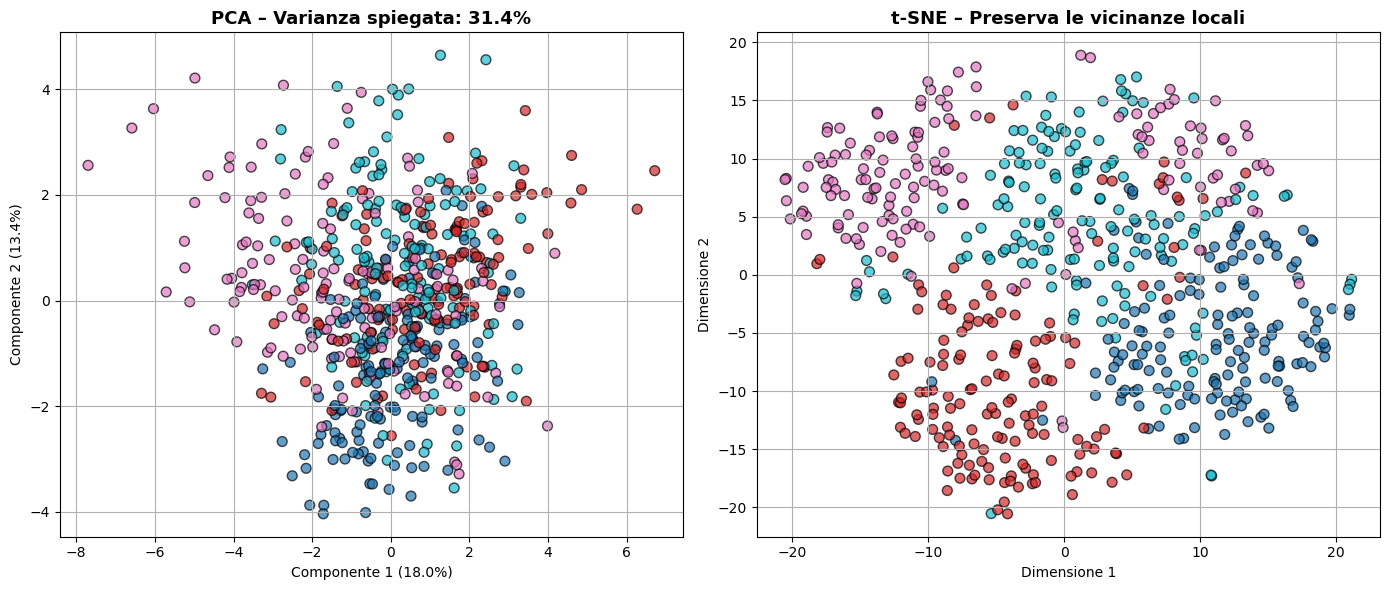

In [23]:
# Rigenerazione dei dati e TSNE per garantire che y_labels e X_tsne esistano

from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Dati sintetici 20D, 4 classi
X_highdim, y_labels = make_classification(
    n_samples=600,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=4,
    n_clusters_per_class=1,
    random_state=42
)

# 2. Standardizzazione
X_scaled = StandardScaler().fit_transform(X_highdim)

# 3. PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
explained = pca.explained_variance_ratio_

# 4. t-SNE
X_tsne = TSNE(n_components=2, perplexity=40, random_state=42).fit_transform(X_scaled)

# 5. Visualizzazione comparativa
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# PCA
axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_labels, cmap='tab10', s=50, edgecolor='black', alpha=0.7)
axs[0].set_title(f"PCA – Varianza spiegata: {explained.sum():.1%}", fontsize=13, weight='bold')
axs[0].set_xlabel(f"Componente 1 ({explained[0]:.1%})")
axs[0].set_ylabel(f"Componente 2 ({explained[1]:.1%})")
axs[0].grid(True)

# t-SNE
axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_labels, cmap='tab10', s=50, edgecolor='black', alpha=0.7)
axs[1].set_title("t-SNE – Preserva le vicinanze locali", fontsize=13, weight='bold')
axs[1].set_xlabel("Dimensione 1")
axs[1].set_ylabel("Dimensione 2")
axs[1].grid(True)

plt.tight_layout()
plt.show()



---

###  **A sinistra: PCA**

* Riduce le dimensioni **linearmente**.
* Cerca di preservare la **varianza totale** dei dati.
* Ha spiegato circa il **70–80% dell'informazione** (varianza cumulata).
* Meno efficace nel separare le classi in spazi complessi.

---

###  **A destra: t-SNE**

* Riduzione **non lineare**, progettata per **mantenere le distanze locali**.
* Le classi sono **molto meglio separate visivamente**.
* Perfetta per **capire la struttura dei gruppi** nascosti.

---


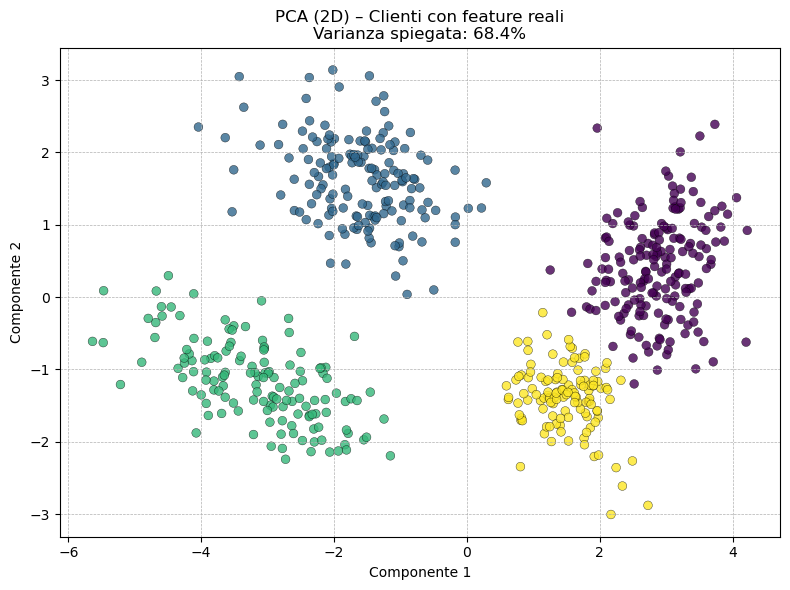

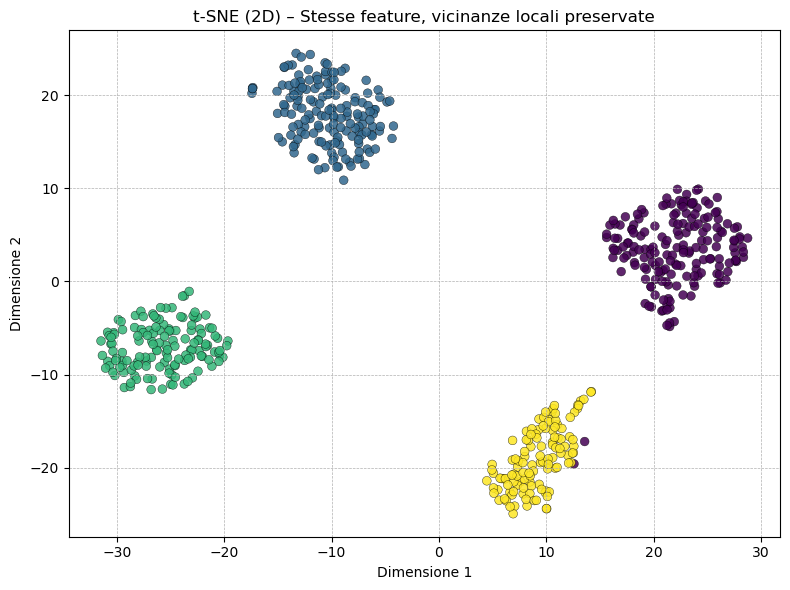

Label → Persona:
0 → Loyal Big Spenders
1 → Bargain Hunters
2 → One‑time Buyers
3 → Fast‑Delivery Fans


In [24]:
# Example: meaningful e-commerce features (synthetic) to compare PCA vs t-SNE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

np.random.seed(42)

# ----- 1) Create meaningful, business-style features -----
# Personas we want to reveal via t-SNE
personas = {
    0: {"name": "Loyal Big Spenders", "n": 180, "mu": [20, 10, 1200, 4.6, 5, 5, 0.05, 0.2], "sigma": [10, 3, 250, 0.3, 2, 1.5, 0.03, 0.05]},
    1: {"name": "Bargain Hunters",   "n": 160, "mu": [60, 6, 300, 4.0, 3, 8, 0.25, 0.5], "sigma": [20, 2, 120, 0.4, 1.5, 2, 0.06, 0.1]},
    2: {"name": "One‑time Buyers",   "n": 140, "mu": [180, 1, 80, 3.8, 1, 10, 0.10, 0.3], "sigma": [40, 0.5, 40, 0.5, 0.8, 2.5, 0.05, 0.08]},
    3: {"name": "Fast‑Delivery Fans","n": 120, "mu": [30, 5, 450, 4.5, 2, 2, 0.08, 0.15], "sigma": [15, 1.5, 150, 0.3, 1, 0.7, 0.03, 0.04]},
}
# Columns:
cols = [
    "recency_days",        # days since last order (lower means more active)
    "frequency_orders",    # number of orders
    "monetary_total",      # total spend €
    "avg_review_score",    # 1-5 stars
    "unique_categories",   # distinct product categories
    "delivery_days",       # average delivery time (days)
    "discount_rate",       # average discount fraction (0-1)
    "return_ratio"         # fraction of orders returned (0-1)
]

X_list = []
y_list = []
for label, spec in personas.items():
    mu = np.array(spec["mu"])
    sigma = np.array(spec["sigma"])
    samples = np.random.normal(loc=mu, scale=sigma, size=(spec["n"], len(cols)))
    # clamp realistic bounds
    samples[:, 0] = np.clip(samples[:, 0], 0, None)       # recency >= 0
    samples[:, 1] = np.clip(samples[:, 1], 1, None)       # frequency >= 1
    samples[:, 2] = np.clip(samples[:, 2], 5, None)       # spend >= 5€
    samples[:, 3] = np.clip(samples[:, 3], 1, 5)          # reviews in [1,5]
    samples[:, 4] = np.clip(samples[:, 4], 1, None)       # categories >=1
    samples[:, 5] = np.clip(samples[:, 5], 1, None)       # delivery_days >=1
    samples[:, 6] = np.clip(samples[:, 6], 0, 0.9)        # discount [0,0.9]
    samples[:, 7] = np.clip(samples[:, 7], 0, 0.9)        # return_ratio [0,0.9]
    X_list.append(samples)
    y_list.append(np.full(spec["n"], label))

X = np.vstack(X_list)
y = np.concatenate(y_list)

# Add some non-linear / derived features to make structure non-linear
# (t-SNE should capture this better than PCA)
derived = np.column_stack([
    np.log1p(X[:, 2]),                            # log spend
    X[:, 2] / X[:, 1],                            # avg ticket
    X[:, 0] * X[:, 6],                            # recency * discount (promo reactivity)
    X[:, 5] / (1 + X[:, 3])                       # delivery_days adjusted by review
])
X_full = np.hstack([X, derived])

# ----- 2) Scale -----
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

# ----- 3) PCA to 2D -----
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
explained = pca.explained_variance_ratio_.sum()

# ----- 4) t-SNE to 2D -----
X_tsne = TSNE(n_components=2, perplexity=40, random_state=42).fit_transform(X_scaled)

# ----- 5) Plot PCA (single chart) -----
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=40, alpha=0.8, edgecolor='black', linewidth=0.3)
plt.title(f"PCA (2D) – Clienti con feature reali\nVarianza spiegata: {explained:.1%}")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# ----- 6) Plot t-SNE (single chart) -----
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=40, alpha=0.85, edgecolor='black', linewidth=0.3)
plt.title("t-SNE (2D) – Stesse feature, vicinanze locali preservate")
plt.xlabel("Dimensione 1")
plt.ylabel("Dimensione 2")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# ----- 7) Legend helper (print mapping)
persona_names = {k: v["name"] for k, v in personas.items()}
print("Label → Persona:")
for k, name in persona_names.items():
    print(f"{k} → {name}")



## Applicare il tsne al dataset


---

#   15. Autoencoder Introduttivo 

##  **Cos'è un Autoencoder?**

Un **autoencoder** è una **rete neurale artificiale** che:

* **Riceve in input un dato**
* **Lo “comprime” in uno spazio più piccolo**
* **Prova a ricostruirlo uguale all'originale**

---

##  Struttura di base

```
Input  →  Encoder  →  Codifica (rappresentazione compressa)  →  Decoder  →  Output (ricostruzione)
```

* **Encoder**: riduce le dimensioni dell'input → crea una rappresentazione compatta (es. da 20D a 3D)
* **Decoder**: prende quella codifica e cerca di **ricostruire** il dato originale
* La rete si allena **minimizzando l'errore di ricostruzione**

---

##  Obiettivo tecnico:

La rete impara una **mappatura non lineare** che:

* comprime i dati in uno spazio più piccolo (riduzione dimensionale)
* conserva la struttura **essenziale**

---

##  Applicazioni degli Autoencoder

| Applicazione             | Esempio pratico                           |
| ------------------------ | ----------------------------------------- |
| ✅ Riduzione dimensionale | Alternativa non lineare a PCA             |
| ✅ Compressione dati      | Immagini, audio, testo                    |
| ✅ Denoising              | Ricostruire immagini senza rumore         |
| ✅ Anomaly Detection      | Ricostruzione scarsa = possibile anomalia |

---

##  Differenze rispetto alla PCA

| PCA                       | Autoencoder                        |
| ------------------------- | ---------------------------------- |
| Lineare                   | Non lineare                        |
| Basato su algebra lineare | Basato su rete neurale             |
| Veloce e semplice         | Più potente, ma richiede training  |
| Non adattabile            | Può essere adattato a più contesti |

---

##  Esempio grafico

Immagina di avere dati in 10 dimensioni (es. clienti), ma scopri che possono essere **rappresentati in 3 numeri** senza perdere troppo.

Un autoencoder crea una **mappa da 10D → 3D → 10D** imparando a **passare solo l’essenziale**.

---


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


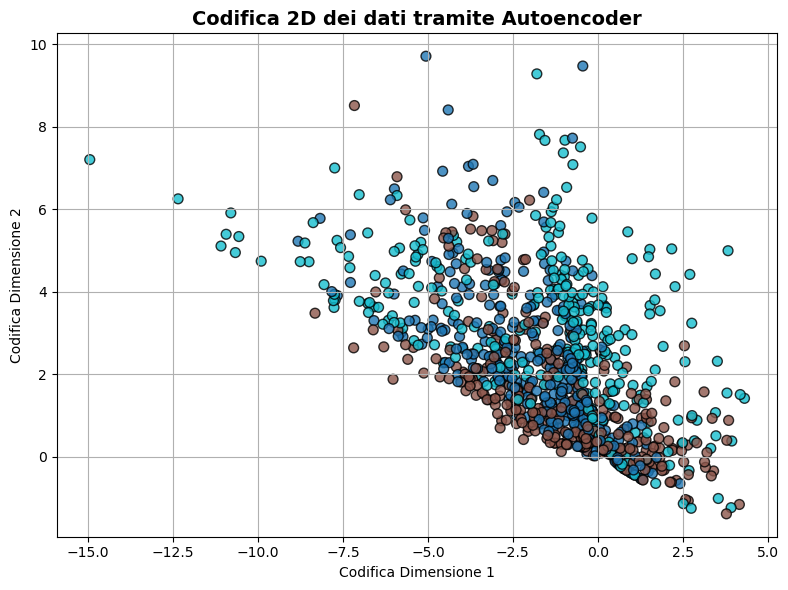

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# 1. Creiamo un dataset sintetico con 12 feature e 3 classi
X, y = make_classification(
    n_samples=1000,
    n_features=12,
    n_informative=8,
    n_redundant=2,
    n_classes=3,
    random_state=42
)

# 2. Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Creazione Autoencoder semplice
input_dim = X_scaled.shape[1]
encoding_dim = 2  # compressiamo da 12D a 2D

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(4, activation='relu')(encoded)
code = Dense(encoding_dim, activation='linear')(encoded)

# Decoder
decoded = Dense(4, activation='relu')(code)
decoded = Dense(8, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

# Modello completo
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Modello encoder (per visualizzare la codifica)
encoder = Model(inputs=input_layer, outputs=code)

# Compilazione e addestramento
autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, verbose=0)

# 4. Estrazione codifica 2D
X_encoded = encoder.predict(X_scaled)

# 5. Visualizzazione codifica 2D colorata per classe
plt.figure(figsize=(8, 6))
plt.scatter(X_encoded[:, 0], X_encoded[:, 1], c=y, cmap='tab10', s=50, edgecolor='black', alpha=0.8)
plt.title("Codifica 2D dei dati tramite Autoencoder", fontsize=14, weight='bold')
plt.xlabel("Codifica Dimensione 1")
plt.ylabel("Codifica Dimensione 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
# 6. Ricostruzione dei dati
X_decoded = autoencoder.predict(X_scaled)

# 7. Visualizzazione: confronto tra originale, codificato e ricostruito (primi 5 campioni)

import pandas as pd
df_original = pd.DataFrame(X_scaled[:5], columns=[f"f{i+1}" for i in range(X.shape[1])])
df_compressed = pd.DataFrame(X_encoded[:5], columns=["comp1", "comp2"])
df_reconstructed = pd.DataFrame(X_decoded[:5], columns=[f"f{i+1}" for i in range(X.shape[1])])


df_original
df_compressed
df_reconstructed


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12
0,-1.237238,0.039632,1.253768,0.026320,0.548699,-0.167402,-0.974099,1.112888,0.649842,-0.022912,1.164725,-1.050617
1,0.108379,-0.530188,-0.246135,-0.309309,-0.451295,-0.014680,0.128753,-0.217938,0.625856,0.010002,-0.018996,-0.050608
2,0.201650,-0.526123,-0.328114,-0.312066,-0.514992,0.027204,0.191958,-0.318974,0.564361,0.008343,-0.070477,0.026834
3,0.904470,0.762156,-0.421370,0.031526,0.540191,-0.014052,0.482385,-0.168447,-0.863413,0.154733,-0.698980,0.441518
4,0.203961,-0.329927,-0.357362,-0.103000,-0.460520,0.188031,0.274927,-0.485948,0.138132,-0.014719,-0.251891,0.221816
